<a href="https://colab.research.google.com/github/Akhilesh-K-Yadav/Image_Segmentation/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 7.9 MB/s 
     |████████████████████████████████| 376 kB 56.6 MB/s 
     |████████████████████████████████| 58 kB 8.5 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=0894c81b84dfcbb4a81d800c5fc401cb729d79814f704b442cf98c2ed1f74c14
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=5d44b2b0b898603258009baf326199c2f784752b745e4c39fb31fc9ffb78e712
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 45.81 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [5]:
#Configs:
CSV_PATH = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'
DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_PATH)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[4]
img_pth = row.images
mask_pth = row.masks

image = cv2.imread(img_pth)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_pth, cv2.IMREAD_GRAYSCALE)/255.0

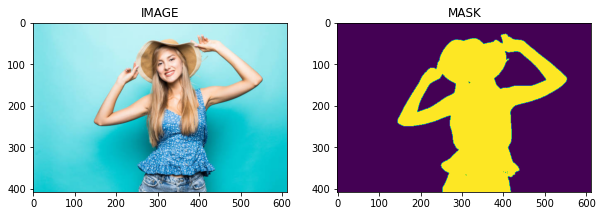

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask)

In [44]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [45]:
import albumentations as A

def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_val_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

In [46]:
#Dataset and Dataloader

from torch.utils.data import Dataset, DataLoader

class SegmentationDS(Dataset):
  def __init__(self, df, augs):
    self.df = df
    self.augs = augs

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = df.iloc[idx]
    img_pth = row.images
    mask_pth = row.masks

    image = cv2.imread(img_pth)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_pth, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1) #Added dim for num_channel as h, w, c

    if self.augs:
      data = self.augs(image=image, mask=mask)
      image = data['image']
      mask = data['mask']
    
    #(h,w,c) -> (c,h,w)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image, mask

In [47]:
trainset = SegmentationDS(train_df, get_train_augs())
valset = SegmentationDS(val_df, get_val_augs())

In [48]:
len(trainset), len(valset)

(232, 58)

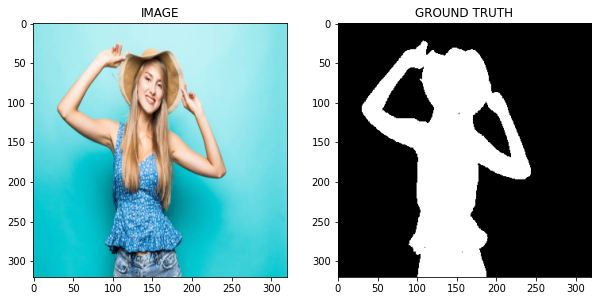

In [49]:
image, mask = trainset[4]
helper.show_image(image, mask)

In [50]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader  = DataLoader(valset, batch_size=BATCH_SIZE)

In [51]:
len(trainloader), len(valloader)

(15, 4)

In [29]:
#Segmentation Model
#segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss


In [37]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arch = smp.Unet(
        encoder_name= ENCODER,
        encoder_weights= WEIGHTS,
        in_channels= 3,
        classes= 1,
        activation= None
    )

  def forward(self, images, masks=None):
    logits = self.arch(images)
    if masks != None:
      loss_dice = DiceLoss(mode='binary')(logits, masks)
      loss_bce = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss_dice + loss_bce
    
    return logits


In [38]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arch): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, ep

In [52]:
# Train and eval funcs:

def train_func(trainloader, model, optimizer):
  total_loss = 0.0
  model.train()

  for images, masks in tqdm(trainloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  
  return total_loss/ len(trainloader)

def eval_func(valloader, model):
  total_loss = 0.0
  model.eval()

  for images, masks in tqdm(valloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    logits, loss = model(images, masks)
    
    total_loss += loss.item()
  
  return total_loss/ len(valloader)



In [53]:
#Training

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

best_val_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_func( trainloader, model, optimizer)
  val_loss = eval_func(valloader, model)

  if val_loss < best_val_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Model saved!")
    best_val_loss = val_loss

  print(f"Epoch={i+1}, train_loss= {train_loss}, val_loss={val_loss}")

100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Model saved!
Epoch=1, train_loss= 0.46189948320388796, val_loss=0.4444737508893013


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Model saved!
Epoch=2, train_loss= 0.3147456775108973, val_loss=0.18523834086954594


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Epoch=3, train_loss= 0.2725179046392441, val_loss=0.1954488642513752


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Model saved!
Epoch=4, train_loss= 0.2973417749007543, val_loss=0.1470809392631054


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch=5, train_loss= 0.22311620116233827, val_loss=0.1721775084733963


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


Model saved!
Epoch=6, train_loss= 0.18806869784990946, val_loss=0.13740235194563866


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


Model saved!
Epoch=7, train_loss= 0.19677632997433345, val_loss=0.11587831005454063


100%|██████████| 4/4 [00:00<00:00,  5.18it/s]


Model saved!
Epoch=8, train_loss= 0.1797739416360855, val_loss=0.11290981993079185


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


Model saved!
Epoch=9, train_loss= 0.1635168418288231, val_loss=0.10744998417794704


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Model saved!
Epoch=10, train_loss= 0.1606532484292984, val_loss=0.09159358590841293


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


Epoch=11, train_loss= 0.14771037449439367, val_loss=0.0933755598962307


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


Epoch=12, train_loss= 0.23502594828605652, val_loss=0.24740086868405342


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Epoch=13, train_loss= 0.20454223503669103, val_loss=0.10410317219793797


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Epoch=14, train_loss= 0.18923864712317784, val_loss=0.13537366315722466


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Epoch=15, train_loss= 0.16798617839813232, val_loss=0.11864420212805271


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Epoch=16, train_loss= 0.1740565314888954, val_loss=0.11026631109416485


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


Model saved!
Epoch=17, train_loss= 0.16983690708875657, val_loss=0.09012129530310631


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


Epoch=18, train_loss= 0.16979668984810511, val_loss=0.10607853531837463


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


Epoch=19, train_loss= 0.15263535877068837, val_loss=0.09233171306550503


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Epoch=20, train_loss= 0.11985847453276316, val_loss=0.09526939131319523


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


Model saved!
Epoch=21, train_loss= 0.18488633533318838, val_loss=0.08770552277565002


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


Epoch=22, train_loss= 0.1682517761985461, val_loss=0.12265731953084469


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


Epoch=23, train_loss= 0.16237469812234243, val_loss=0.10225250944495201


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


Epoch=24, train_loss= 0.16005006829897564, val_loss=0.09275922738015652


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Model saved!
Epoch=25, train_loss= 0.16368265797694523, val_loss=0.08270818553864956


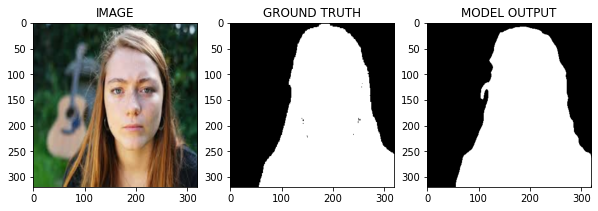

In [62]:
#Inference
model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = valset[6]
out_mask = model(image.to(DEVICE).unsqueeze(0))
pred = torch.sigmoid(out_mask)
pred = (pred > 0.5) * 1

helper.show_image(image, mask, pred.detach().cpu().squeeze(0))


In [63]:
pred

tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 1, 1, 0],
          [0, 0, 0,  ..., 1, 0, 0],
          [0, 0, 0,  ..., 1, 0, 0]]]], device='cuda:0')